In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def predict_devanagari_character(image_path, model_path='models/devanagari_model.h5', metadata_path='models/model_metadata.npy'):
    """
    Predict Devanagari character from an image

    Args:
        image_path: Path to the input image
        model_path: Path to the saved model
        metadata_path: Path to the model metadata

    Returns:
        predicted_class: The predicted class index
        confidence: The confidence score for the prediction
    """
    # Load the model and metadata
    # Suppress the warning about compiled metrics not being built
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = load_model(model_path)

    metadata = np.load(metadata_path, allow_pickle=True).item()

    # Read and preprocess the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Could not read image at {image_path}")

    # Resize image to match model's expected input
    img = cv2.resize(img, (32, 32))

    # Normalize and reshape image
    img = img.reshape(1, 32, 32, 1) / 255.0

    # Make prediction
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class]

    return predicted_class, confidence

def get_character_info(class_idx):
    """
    Get information about the predicted character from the labels.csv file

    Args:
        class_idx: The predicted class index

    Returns:
        character_info: Dictionary containing character information
    """
    # Read the labels file
    labels_df = pd.read_csv('dataset/labels.csv', skiprows=2)

    # Find the row with the matching class index
    # We need to drop rows where 'Class' is NaN before searching
    character_row = labels_df.dropna(subset=['Class'])[labels_df.dropna(subset=['Class'])['Class'] == class_idx]

    if not character_row.empty:
        # Assuming 'Category' column is present and correctly filled
        category = character_row['Category'].iloc[0] if 'Category' in character_row.columns else 'Unknown Category'
        character_info = {
            'type': category,
            'label': character_row['Label'].iloc[0],
            'devanagari': character_row['Devanagari Label'].iloc[0],
            'phonetics': character_row['Phonetics'].iloc[0]
        }
        return character_info
    else:
        return None


# Example usage:
def predict_and_display(image_path):
    """
    Predict character and display results with the image

    Args:
        image_path: Path to the input image
    """
    # Make prediction
    predicted_class, confidence = predict_devanagari_character(image_path)

    # Get character information
    character_info = get_character_info(predicted_class)

    # Display results
    print("\nPrediction Results:")
    print(f"Confidence: {confidence:.2%}")
    if character_info:
        print(f"Type: {character_info['type']}")
        print(f"Label: {character_info['label']}")
        print(f"Devanagari: {character_info['devanagari']}")
        print(f"Phonetics: {character_info['phonetics']}")
    else:
        print(f"Could not find character information for class index {predicted_class}")

    # Display the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        plt.figure(figsize=(4, 4))
        plt.imshow(img, cmap='gray')
        # Use Devanagari label if available, otherwise use predicted class index
        title = f"Predicted: {character_info['devanagari'] if character_info and 'devanagari' in character_info else predicted_class}"
        plt.title(title)
        plt.axis('off')
        plt.show()
    else:
        print(f"Could not load image for display: {image_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step

Prediction Results:
Confidence: 26.19%
Could not find character information for class index 10


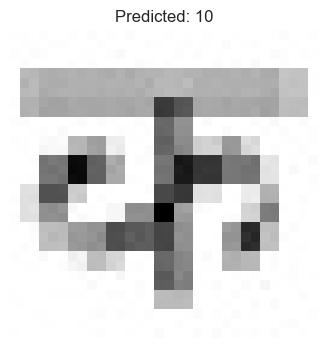

In [23]:
# Example: Test with an image from your dataset
test_image_path = "dataset/nhcd/nhcd/consonants/1/21.jpg"  # Replace with an actual image path
predict_and_display(test_image_path)